In [0]:
!pip freeze

absl-py==0.9.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
asgiref==3.2.7
astor==0.8.1
astropy==4.0.1.post1
astunparse==1.6.3
atari-py==0.2.6
atomicwrites==1.4.0
attrs==19.3.0
audioread==2.1.8
autograd==1.3
Babel==2.8.0
backcall==0.1.0
beautifulsoup4==4.6.3
bleach==3.1.5
blis==0.4.1
bokeh==1.4.0
boto==2.49.0
boto3==1.13.13
botocore==1.16.13
Bottleneck==1.3.2
branca==0.4.1
bs4==0.0.1
CacheControl==0.12.6
cachetools==3.1.1
catalogue==1.0.0
certifi==2020.4.5.1
cffi==1.14.0
chainer==6.5.0
chardet==3.0.4
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.4.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.2.1
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda101==6.5.0
cvxopt==1.2.5
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.3
Cython==0.29.18
daft==0.0.4
dask==2.12.0
dataclasses==0.7
datascience==0.10.6
decorator==4.4.2
defusedxml==0.6.0
descartes==1.1.0
dill==0.3.1.1
distributed==1.25.3
Django==3.0.6
dlib==19.18.0
docopt==0.6.2
doc

In [0]:
!pwd

/content/drive


In [0]:
%cd drive/

/content/drive


In [0]:
from google.colab import drive 
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install torch>=0.4.1
!pip install torchvision>=0.2.1
!pip install dominate>=2.3.1
!pip install visdom>=0.1.8.
!pip install tensorboard
!pip install tensorboardX

/bin/bash: =0.4.1: Operation not supported
/bin/bash: =0.2.1: Operation not supported
/bin/bash: =2.3.1: Operation not supported
/bin/bash: =0.1.8.: Operation not supported
     |████████████████████████████████| 204kB 4.9MB/s 


以下、cycle-GAN（石井さんパート）を用いての deep fakeを行う処理。

In [0]:
import glob
import random
import os

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F


In [0]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, '%s/A' % mode) + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '%s/B' % mode) + '/*.*'))

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]).convert('RGB'))

        if self.unaligned:
            item_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]).convert('RGB'))
        else:
            item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]).convert('RGB'))

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [0]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.conv_block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.conv_block(x)

In [0]:
class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),

            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),

            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, 7),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


In [0]:

class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128), 
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256), 
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, padding=1),
            nn.InstanceNorm2d(512), 
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, x):
        x =  self.model(x)
        # Average pooling and flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

In [0]:
import random
import time
import datetime
import sys

from torch.autograd import Variable
import torch
from visdom import Visdom
import numpy as np

def tensor2image(tensor):
    image = 127.5*(tensor[0].cpu().float().numpy() + 1.0)
    if image.shape[0] == 1:
        image = np.tile(image, (3,1,1))
    return image.astype(np.uint8)

class Logger():
    def __init__(self, n_epochs, batches_epoch):
        self.viz = Visdom()
        self.n_epochs = n_epochs
        self.batches_epoch = batches_epoch
        self.epoch = 1
        self.batch = 1
        self.prev_time = time.time()
        self.mean_period = 0
        self.losses = {}
        self.loss_windows = {}
        self.image_windows = {}


    def log(self, losses=None, images=None):
        self.mean_period += (time.time() - self.prev_time)
        self.prev_time = time.time()

        print('\rEpoch %03d/%03d [%04d/%04d] -- ' % (self.epoch, self.n_epochs, self.batch, self.batches_epoch))

        for i, loss_name in enumerate(losses.keys()):
            if loss_name not in self.losses:
                self.losses[loss_name] = losses[loss_name].data.item()
            else:
                self.losses[loss_name] += losses[loss_name].data.item()

            if (i+1) == len(losses.keys()):
                print('%s: %.4f -- ' % (loss_name, self.losses[loss_name]/self.batch))
            else:
                print('%s: %.4f | ' % (loss_name, self.losses[loss_name]/self.batch))

        batches_done = self.batches_epoch*(self.epoch - 1) + self.batch
        batches_left = self.batches_epoch*(self.n_epochs - self.epoch) + self.batches_epoch - self.batch 
        print('ETA: %s' % (datetime.timedelta(seconds=batches_left*self.mean_period/batches_done)))

        # Draw images
        for image_name, tensor in images.items():
            if image_name not in self.image_windows:
                self.image_windows[image_name] = self.viz.image(tensor2image(tensor.data), opts={'title':image_name})
            else:
                self.viz.image(tensor2image(tensor.data), win=self.image_windows[image_name], opts={'title':image_name})

        # End of epoch
        if (self.batch % self.batches_epoch) == 0:
            # Plot losses
            for loss_name, loss in self.losses.items():
                if loss_name not in self.loss_windows:
                    self.loss_windows[loss_name] = self.viz.line(X=np.array([self.epoch]), Y=np.array([loss/self.batch]), 
                                                                    opts={'xlabel': 'epochs', 'ylabel': loss_name, 'title': loss_name})
                else:
                    self.viz.line(X=np.array([self.epoch]), Y=np.array([loss/self.batch]), win=self.loss_windows[loss_name], update='append')
                # Reset losses for next epoch
                self.losses[loss_name] = 0.0

            self.epoch += 1
            self.batch = 1
        else:
            self.batch += 1

In [0]:
# 過去の生成データ(50iter分)を保持しておく
class ReplayBuffer():
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            #
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))


In [0]:
class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        #assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)

In [0]:
!mkdir -p output
!ls output

netD_A.pth  netD_B.pth	netG_A2B.pth  netG_B2A.pth


In [0]:
#!ls output
#!mv output/netG_A2B.pth output/netG_A2B.pth.bk0
#!mv output/netG_B2A.pth output/netG_B2A.pth.bk0
#!mv output/netG_A2B.pth.bk1 output/netG_A2B.pth
#!mv output/netG_B2A.pth.bk1 output/netG_B2A.pth


In [0]:
#!ls
!ls -l ./output

total 110528
-rw------- 1 root root 11060741 May 20 15:10 netD_A.pth
-rw------- 1 root root 11060741 May 20 15:10 netD_B.pth
-rw------- 1 root root 45524057 May 20 15:10 netG_A2B.pth
-rw------- 1 root root 45524057 May 20 15:10 netG_B2A.pth


In [0]:
#!tar zxvf output_70epoch.tar.gz

In [0]:
#!mv netG_A2B.pth output/
#!mv netG_B2A.pth output/

In [0]:
import argparse
import itertools

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from PIL import Image
import torch

parser = argparse.ArgumentParser()
parser.add_argument('--epoch', type=int, default=120, help='starting epoch')
parser.add_argument('--n_epochs', type=int, default=230, help='number of epochs of training')
parser.add_argument('--batchSize', type=int, default=1, help='size of the batches')
parser.add_argument('--dataroot', type=str, default='datasets/photo2picasso/', help='root directory of the dataset')
parser.add_argument('--lr', type=float, default=0.0002, help='initial learning rate')
parser.add_argument('--decay_epoch', type=int, default=200, help='epoch to start linearly decaying the learning rate to 0')
parser.add_argument('--size', type=int, default=256, help='size of the data crop (squared assumed)')
parser.add_argument('--input_nc', type=int, default=3, help='number of channels of input data')
parser.add_argument('--output_nc', type=int, default=3, help='number of channels of output data')
#parser.add_argument('--cuda', action='store_true', help='use GPU computation')
parser.add_argument('--cpu', action='store_true', help='use CPU computation')
parser.add_argument('--n_cpu', type=int, default=8, help='number of cpu threads to use during batch generation')

opt = parser.parse_args(args=['--dataroot', 'datasets/photo2portrait/'])
#opt = parser.parse_args(args=['--dataroot', 'datasets/photo2picasso/'])
print(opt)

is_cpu = opt.cpu or not torch.cuda.is_available()
opt.device_name = "cpu" if is_cpu else "cuda:0"
opt.device = torch.device(opt.device_name)

###### Definition of variables ######
# Networks
netG_A2B = Generator(opt.input_nc, opt.output_nc)
netG_B2A = Generator(opt.output_nc, opt.input_nc)
netD_A = Discriminator(opt.input_nc)
netD_B = Discriminator(opt.output_nc)

if not opt.cpu:
    netG_A2B.cuda()
    netG_B2A.cuda()
    netD_A.cuda()
    netD_B.cuda()

#.to(self.config.device)

netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

# Load network
if True:
    netG_A2B.load_state_dict(torch.load("./output/netG_A2B.pth", map_location="cuda:0"), strict=False)
    netG_B2A.load_state_dict(torch.load("./output/netG_B2A.pth", map_location="cuda:0"), strict=False)
    netD_A.load_state_dict(torch.load("./output/netD_A.pth", map_location="cuda:0"), strict=False)
    netD_B.load_state_dict(torch.load("./output/netD_B.pth", map_location="cuda:0"), strict=False)

# Lossess
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

# Optimizers & LR schedulers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=opt.lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=opt.lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=opt.lr, betas=(0.5, 0.999))

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)

# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if not opt.cpu else torch.Tensor
input_A = Tensor(opt.batchSize, opt.input_nc, opt.size, opt.size)
input_B = Tensor(opt.batchSize, opt.output_nc, opt.size, opt.size)
target_real = Variable(Tensor(opt.batchSize).fill_(1.0), requires_grad=False)
target_fake = Variable(Tensor(opt.batchSize).fill_(0.0), requires_grad=False)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

# Dataset loader
transforms_ = [ transforms.Resize(int(opt.size*1.12), Image.BICUBIC), 
                transforms.RandomCrop(opt.size), 
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
dataloader = DataLoader(ImageDataset(opt.dataroot, transforms_=transforms_, unaligned=True), 
                        batch_size=opt.batchSize, shuffle=True, num_workers=opt.n_cpu)

print("num dataloader= {}".format(len(dataloader)))

Namespace(batchSize=1, cpu=False, dataroot='datasets/photo2portrait/', decay_epoch=200, epoch=120, input_nc=3, lr=0.0002, n_cpu=8, n_epochs=230, output_nc=3, size=256)
num dataloader= 638


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  


In [0]:
#!ls datasets/photo2portrait/

In [0]:
!ls ./

sample_data


In [0]:
# Loss plot
#logger = Logger(opt.n_epochs, len(dataloader))
###################################

###### Training ######
for epoch in range(opt.epoch, opt.n_epochs):
    for i, batch in enumerate(dataloader):
        # Set model input
        real_A = Variable(input_A.copy_(batch['A']))
        real_B = Variable(input_B.copy_(batch['B']))

        ###### Generators A2B and B2A ######
        optimizer_G.zero_grad()

        # Identity loss
        # G_A2B(B) should equal B if real B is fed
        same_B = netG_A2B(real_B)
        loss_identity_B = criterion_identity(same_B, real_B)*5.0
        # G_B2A(A) should equal A if real A is fed
        same_A = netG_B2A(real_A)
        loss_identity_A = criterion_identity(same_A, real_A)*5.0

        # GAN loss
        fake_B = netG_A2B(real_A)
        pred_fake = netD_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

        fake_A = netG_B2A(real_B)
        pred_fake = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

        # Cycle loss
        recovered_A = netG_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0

        recovered_B = netG_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0

        # Total loss
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward()
        
        optimizer_G.step()
        ###################################

        ###### Discriminator A ######
        optimizer_D_A.zero_grad()

        # Real loss
        pred_real = netD_A(real_A)
        loss_D_real = criterion_GAN(pred_real, target_real)

        # Fake loss
        fake_A = fake_A_buffer.push_and_pop(fake_A)
        pred_fake = netD_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        loss_D_A.backward()

        optimizer_D_A.step()
        ###################################

        ###### Discriminator B ######
        optimizer_D_B.zero_grad()

        # Real loss
        pred_real = netD_B(real_B)
        loss_D_real = criterion_GAN(pred_real, target_real)
        
        # Fake loss
        fake_B = fake_B_buffer.push_and_pop(fake_B)
        pred_fake = netD_B(fake_B.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        loss_D_B.backward()

        optimizer_D_B.step()
        ###################################

        # Progress report (http://localhost:8097)
        #logger.log({'loss_G': loss_G, 'loss_G_identity': (loss_identity_A + loss_identity_B), 'loss_G_GAN': (loss_GAN_A2B + loss_GAN_B2A),
        #            'loss_G_cycle': (loss_cycle_ABA + loss_cycle_BAB), 'loss_D': (loss_D_A + loss_D_B)}, 
        #            images={'real_A': real_A, 'real_B': real_B, 'fake_A': fake_A, 'fake_B': fake_B})
        if i % 10 == 0:
            print('Epoch[{}]({}/{}) loss_G: {} loss_G_identity: {} loss_G_GAN: {} loss_G_cycle: {} loss_D: {}'.format(
                epoch, i, len(dataloader), loss_G, (loss_identity_A + loss_identity_B),
                (loss_GAN_A2B + loss_GAN_B2A), (loss_cycle_ABA + loss_cycle_BAB), (loss_D_A + loss_D_B)
                ))

    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    # Save models checkpoints
    torch.save(netG_A2B.state_dict(), './output/netG_A2B.pth')
    torch.save(netG_B2A.state_dict(), './output/netG_B2A.pth')
    torch.save(netD_A.state_dict(), './output/netD_A.pth')
    torch.save(netD_B.state_dict(), './output/netD_B.pth')
    
    !cp -f './output/netG_A2B.pth' 'gdrive/My Drive/'
    !cp -f './output/netG_B2A.pth' 'gdrive/My Drive/'
    !cp -f './output/netD_A.pth' 'gdrive/My Drive/'
    !cp -f './output/netD_B.pth' 'gdrive/My Drive/'
   

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ストリーミング出力は最後の 5000 行に切り捨てられました。
Epoch[151](570/638) loss_G: 3.658334732055664 loss_G_identity: 0.5464367866516113 loss_G_GAN: 1.5964142084121704 loss_G_cycle: 1.5154838562011719 loss_D: 0.09857567399740219
Epoch[151](580/638) loss_G: 5.643950939178467 loss_G_identity: 0.8541597127914429 loss_G_GAN: 2.580862522125244 loss_G_cycle: 2.2089285850524902 loss_D: 0.07741960138082504
Epoch[151](590/638) loss_G: 3.065476417541504 loss_G_identity: 0.5947551727294922 loss_G_GAN: 0.8165336847305298 loss_G_cycle: 1.6541876792907715 loss_D: 0.20768806338310242
Epoch[151](600/638) loss_G: 3.9427781105041504 loss_G_identity: 0.7589439153671265 loss_G_GAN: 1.1014306545257568 loss_G_cycle: 2.0824034214019775 loss_D: 0.20736195147037506
Epoch[151](610/638) loss_G: 3.4878792762756348 loss_G_identity: 0.9533416628837585 loss_G_GAN: 0.6333195567131042 loss_G_cycle: 1.901218056678772 loss_D: 0.1365971565246582
Epoch[151](620/638) loss_G: 5.081128120422363 loss_G_identity: 0.7911993265151978 loss_G_GAN: 1.927

In [0]:
!ls

'=0.1.8.'  '=0.4.1'   datasets	        gdrive	 sample_data
'=0.2.1'   '=2.3.1'   datasets.tar.gz   output


In [0]:
import argparse
import itertools

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from PIL import Image
import torch

from torchvision.utils import save_image
parser = argparse.ArgumentParser()
parser.add_argument('--batchSize', type=int, default=1, help='size of the batches')
parser.add_argument('--dataroot', type=str, default='datasets/horse2zebra/', help='root directory of the dataset')
parser.add_argument('--input_nc', type=int, default=3, help='number of channels of input data')
parser.add_argument('--output_nc', type=int, default=3, help='number of channels of output data')
parser.add_argument('--size', type=int, default=256, help='size of the data (squared assumed)')
parser.add_argument('--cuda', action='store_true', help='use GPU computation')
parser.add_argument('--n_cpu', type=int, default=8, help='number of cpu threads to use during batch generation')
parser.add_argument('--generator_A2B', type=str, default='gdrive/My Drive/netG_A2B.pth', help='A2B generator checkpoint file')
parser.add_argument('--generator_B2A', type=str, default='gdrive/My Drive/netG_B2A.pth', help='B2A generator checkpoint file')

opt = parser.parse_args(args=['--dataroot', 'datasets/photo2portrait/', '--cuda'])
print(opt)


###### Definition of variables ######
# Networks
netG_A2B = Generator(opt.input_nc, opt.output_nc)
netG_B2A = Generator(opt.output_nc, opt.input_nc)

if opt.cuda:
    netG_A2B.cuda()
    netG_B2A.cuda()

# Load state dicts
netG_A2B.load_state_dict(torch.load(opt.generator_A2B))
netG_B2A.load_state_dict(torch.load(opt.generator_B2A))

# Set model's test mode
netG_A2B.eval()
netG_B2A.eval()

# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if opt.cuda else torch.Tensor
input_A = Tensor(opt.batchSize, opt.input_nc, opt.size, opt.size)
input_B = Tensor(opt.batchSize, opt.output_nc, opt.size, opt.size)

# Dataset loader
transforms_ = [transforms.Resize(int(opt.size*1.0), Image.BICUBIC), 
                transforms.RandomCrop(opt.size), 
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
dataloader = DataLoader(ImageDataset(opt.dataroot, transforms_=transforms_, mode='train'), 
                        batch_size=opt.batchSize, shuffle=False, num_workers=opt.n_cpu)
###################################

###### Testing######

# Create output dirs if they don't exist
if not os.path.exists('output/A'):
    os.makedirs('output/A')
if not os.path.exists('output/B'):
    os.makedirs('output/B')

for i, batch in enumerate(dataloader):
    # Set model input
    real_A = Variable(input_A.copy_(batch['A']))
    real_B = Variable(input_B.copy_(batch['B']))

    # Generate output
    fake_B = 0.5*(netG_A2B(real_A).data + 1.0)
    fake_A = 0.5*(netG_B2A(real_B).data + 1.0)

    out_img1 = torch.cat([real_A, fake_B], dim=2)
    out_img2 = torch.cat([real_B, fake_A], dim=2)

    # Save image files
    save_image(out_img1, 'output/A/%04d.png' % (i+1))
    save_image(out_img2, 'output/B/%04d.png' % (i+1))

    print('\rGenerated images %04d of %04d' % (i+1, len(dataloader)))

    #if i > 100:
    #    break

###################################

Namespace(batchSize=1, cuda=True, dataroot='datasets/photo2portrait/', generator_A2B='gdrive/My Drive/netG_A2B.pth', generator_B2A='gdrive/My Drive/netG_B2A.pth', input_nc=3, n_cpu=8, output_nc=3, size=256)
Generated images 0001 of 0638
Generated images 0002 of 0638
Generated images 0003 of 0638
Generated images 0004 of 0638
Generated images 0005 of 0638
Generated images 0006 of 0638
Generated images 0007 of 0638
Generated images 0008 of 0638
Generated images 0009 of 0638
Generated images 0010 of 0638
Generated images 0011 of 0638
Generated images 0012 of 0638
Generated images 0013 of 0638
Generated images 0014 of 0638
Generated images 0015 of 0638
Generated images 0016 of 0638
Generated images 0017 of 0638
Generated images 0018 of 0638
Generated images 0019 of 0638
Generated images 0020 of 0638
Generated images 0021 of 0638
Generated images 0022 of 0638
Generated images 0023 of 0638
Generated images 0024 of 0638
Generated images 0025 of 0638
Generated images 0026 of 0638
Generated ima

In [0]:
!ls output

A  B  netD_A.pth  netD_B.pth  netG_A2B.pth  netG_B2A.pth


In [0]:
!tar -zcvf outputA2.tar.gz output/A/*
!cp outputA2.tar.gz gdrive/"My Drive"/

output/A/0001.png
output/A/0002.png
output/A/0003.png
output/A/0004.png
output/A/0005.png
output/A/0006.png
output/A/0007.png
output/A/0008.png
output/A/0009.png
output/A/0010.png
output/A/0011.png
output/A/0012.png
output/A/0013.png
output/A/0014.png
output/A/0015.png
output/A/0016.png
output/A/0017.png
output/A/0018.png
output/A/0019.png
output/A/0020.png
output/A/0021.png
output/A/0022.png
output/A/0023.png
output/A/0024.png
output/A/0025.png
output/A/0026.png
output/A/0027.png
output/A/0028.png
output/A/0029.png
output/A/0030.png
output/A/0031.png
output/A/0032.png
output/A/0033.png
output/A/0034.png
output/A/0035.png
output/A/0036.png
output/A/0037.png
output/A/0038.png
output/A/0039.png
output/A/0040.png
output/A/0041.png
output/A/0042.png
output/A/0043.png
output/A/0044.png
output/A/0045.png
output/A/0046.png
output/A/0047.png
output/A/0048.png
output/A/0049.png
output/A/0050.png
output/A/0051.png
output/A/0052.png
output/A/0053.png
output/A/0054.png
output/A/0055.png
output/A/0

In [0]:
!tar -zcvf outputB2.tar.gz output/B/*
!cp outputB2.tar.gz gdrive/"My Drive"/

output/B/0001.png
output/B/0002.png
output/B/0003.png
output/B/0004.png
output/B/0005.png
output/B/0006.png
output/B/0007.png
output/B/0008.png
output/B/0009.png
output/B/0010.png
output/B/0011.png
output/B/0012.png
output/B/0013.png
output/B/0014.png
output/B/0015.png
output/B/0016.png
output/B/0017.png
output/B/0018.png
output/B/0019.png
output/B/0020.png
output/B/0021.png
output/B/0022.png
output/B/0023.png
output/B/0024.png
output/B/0025.png
output/B/0026.png
output/B/0027.png
output/B/0028.png
output/B/0029.png
output/B/0030.png
output/B/0031.png
output/B/0032.png
output/B/0033.png
output/B/0034.png
output/B/0035.png
output/B/0036.png
output/B/0037.png
output/B/0038.png
output/B/0039.png
output/B/0040.png
output/B/0041.png
output/B/0042.png
output/B/0043.png
output/B/0044.png
output/B/0045.png
output/B/0046.png
output/B/0047.png
output/B/0048.png
output/B/0049.png
output/B/0050.png
output/B/0051.png
output/B/0052.png
output/B/0053.png
output/B/0054.png
output/B/0055.png
output/B/0

In [0]:
!cp outputB.tar.gz gdrive/"My Drive"/
!cp outputA.tar.gz gdrive/"My Drive"/

cp: cannot stat 'outputB.tar.gz': No such file or directory
cp: cannot stat 'outputA.tar.gz': No such file or directory


In [0]:
!ls -a

 .	   '=0.2.1'   .config	   datasets.tar.gz   outputA2.tar.gz
 ..	   '=0.4.1'   datasets	   gdrive	     outputB2.tar.gz
'=0.1.8.'  '=2.3.1'   ._datasets   output	     sample_data


In [0]:
#from google.colab import files
#files.download("outputA.tar.gz")

In [0]:
#from google.colab import files
#files.download("outputB.tar.gz")

In [0]:
!ls

'=0.1.8.'  '=0.4.1'   datasets	        gdrive	 outputA2.tar.gz   sample_data
'=0.2.1'   '=2.3.1'   datasets.tar.gz   output	 outputB2.tar.gz


In [0]:
!cp output/netG_A2B.pth gdrive/"My Drive"/
!cp output/netG_B2A.pth gdrive/"My Drive"/

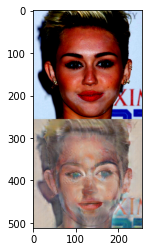

In [0]:
import matplotlib.pyplot as plt
img = plt.imread('output/A/0001.png')
plt.imshow(img)

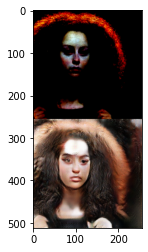

In [0]:
img = plt.imread('output/B/0001.png')
plt.imshow(img)

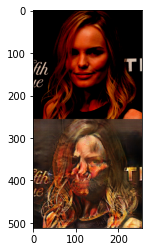

In [0]:
img = plt.imread('output/A/0002.png')
plt.imshow(img)

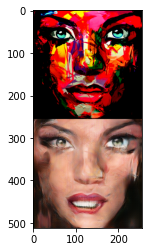

In [0]:
img = plt.imread('output/B/0002.png')
plt.imshow(img)

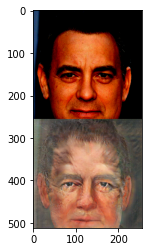

In [0]:
img = plt.imread('output/A/0003.png')
plt.imshow(img)

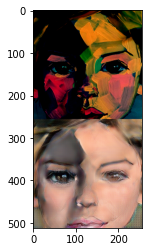

In [0]:
img = plt.imread('output/B/0003.png')
plt.imshow(img)

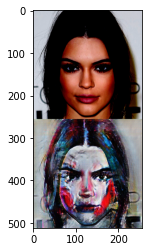

In [0]:
img = plt.imread('output/A/0004.png')
plt.imshow(img)

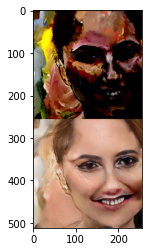

In [0]:
img = plt.imread('output/B/0004.png')
plt.imshow(img)

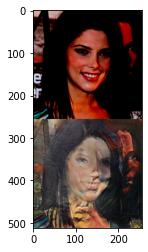

In [0]:
img = plt.imread('output/A/0005.png')
plt.imshow(img)

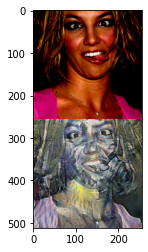

In [0]:
img = plt.imread('output/A/0006.png')
plt.imshow(img)

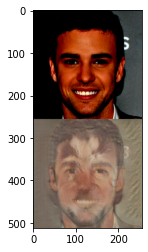

In [0]:
img = plt.imread('output/A/0007.png')
plt.imshow(img)

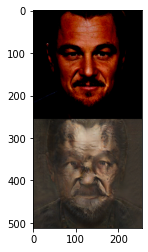

In [0]:
img = plt.imread('output/A/0008.png')
plt.imshow(img)

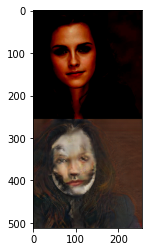

In [0]:
img = plt.imread('output/A/0009.png')
plt.imshow(img)

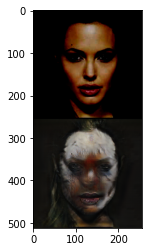

In [0]:
img = plt.imread('output/A/0010.png')
plt.imshow(img)

動画から